In [8]:
%load_ext autoreload
%autoreload 2

In [1]:
"""
Blackbox Attack

The way the blackbox attack works is as follows:
Since we do not know details about the model we are attacking, we train a "substitute model" to approximate the "target model".
This is done using a small sample of training data, labeled by the target model instead of using the ground-truth labels. 
In addition, we augment this training data using "Jacobian-based data augmentation" (TODO)
Finally, we use one of the regular attacks on the substitute model. Supposedly, an attack that works well against the substitute
will also work well against the target. 
"""

'\nBlackbox Attack\n\nThe way the blackbox attack works is as follows:\nSince we do not know details about the model we are attacking, we train a "substitute model" to approximate the "target model".\nThis is done using a small sample of training data, labeled by the target model instead of using the ground-truth labels. \nIn addition, we augment this training data using "Jacobian-based data augmentation" (TODO)\n'

In [37]:
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image 
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

import team36
from team36.mnist.data_loading import MNIST_Loader
from team36.mnist.vgg import VGG
from team36.mnist.cnn import CNN
from team36.attacks.fast_gradient_attack_data_set import FastSignGradientAttackDataSet
from team36.training import train, validate, accuracy, predict, do_training

DIR = '.'
DATA_DIR = f'{DIR}/data'

In [2]:
"""
Step 1
Train the target model (aka the Oracle) on a large portion of the training data, or load a checkpoint
"""

'\nStep 1\nLoad the trained target model (aka the Oracle)\n'

In [10]:
data = torchvision.datasets.MNIST(root=DATA_DIR, train=True, download=True, 
                                          transform=transforms.ToTensor())

C:\Users\bkest\miniconda3\envs\cs7643-final-project-cpu\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [29]:
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [33]:
data.targets[0] = 1

In [34]:
data.targets

tensor([1, 0, 4,  ..., 5, 6, 8])

In [30]:
help(data)

Help on MNIST in module torchvision.datasets.mnist object:

class MNIST(torchvision.datasets.vision.VisionDataset)
 |  MNIST(root: str, train: bool = True, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None, download: bool = False) -> None
 |  
 |  `MNIST <http://yann.lecun.com/exdb/mnist/>`_ Dataset.
 |  
 |  Args:
 |      root (string): Root directory of dataset where ``MNIST/processed/training.pt``
 |          and  ``MNIST/processed/test.pt`` exist.
 |      train (bool, optional): If True, creates dataset from ``training.pt``,
 |          otherwise from ``test.pt``.
 |      download (bool, optional): If true, downloads the dataset from the internet and
 |          puts it in root directory. If dataset is already downloaded, it is not
 |          downloaded again.
 |      transform (callable, optional): A function/transform that  takes in an PIL image
 |          and returns a transformed version. E.g, ``transforms.RandomCrop``
 |      target_transform 

54000 in training set
6000 in validation set
Epoch: [0][0/8]	Loss 2.5890 (2.5890)	Prec @1 0.0859 (0.0859)	
Epoch 0 | Training accuracy: 0.33000001311302185% | Validation accuracy: 0.6349999904632568%
Epoch: [1][0/8]	Loss 1.4118 (1.4118)	Prec @1 0.6016 (0.6016)	
Epoch 1 | Training accuracy: 0.7360000014305115% | Validation accuracy: 0.781166672706604%


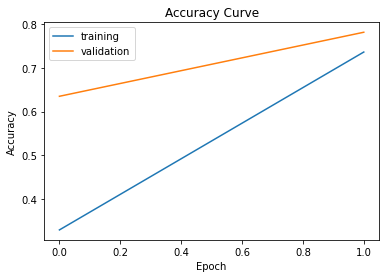

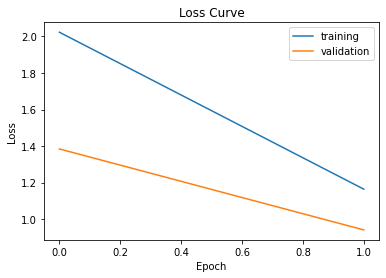

Best Validation Acccuracy: 0.7812


In [44]:
oracle = VGG() # set the target model here
oracle_checkpoint = 'mnist-vgg.pth'
oracle_checkpoint_path = f'{DIR}/checkpoints/{oracle_checkpoint}'
if os.path.exists(oracle_checkpoint_path): # if trained checkpoint exists, load it
    state_dict = torch.load(f"{DIR}/checkpoints/{checkpoint}", map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
else: # else, train the model
    mnist_loader = MNIST_Loader(DIR, DATA_DIR)
    oracle_train_split, oracle_val_split = mnist_loader.train_val_split()
    print(f"{len(oracle_train_split)} in training set")
    print(f"{len(oracle_val_split)} in validation set")
    do_training(oracle, training_split=oracle_train_split, validation_split=oracle_val_split, epochs=2)

In [3]:
"""
Step 2
Train the substitute model on a small portion of the training data, using the oracle's predictions as the labels
"""

'\nStep 2\nTrain the substitute model on a small portion of the training data\n'

In [4]:
"""
Step 3
Generate attack data for the substitute model
"""

'\nStep 3\nGenerate attack data for the substitute model\n'

In [5]:
"""
Step 4
Test the target model against the above attack data
"""

'\nStep 4\nTest the target model against the above attack data\n'